In [95]:
import tensorflow as tf
import os
import random
import numpy as np
import helpers
import cv2 as cv
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [96]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 80
IMG_HEIGHT = 80
IMG_CHANNELS = 3

TRAIN_PATH_IMAGES = 'training/images/'
TRAIN_PATH_GROUNDTRUTH = 'training/groundtruth/'
NEW_TRAIN_PATH_IMAGES = 'new_training/images/'
NEW_TRAIN_PATH_GROUNDTRUTH = 'new_training/groundtruth/'

TEST_PATH = 'test_set_images/'

train_ids = os.listdir(TRAIN_PATH_IMAGES)
new_train_ids = os.listdir(NEW_TRAIN_PATH_IMAGES)
test_ids = os.listdir(TEST_PATH)

# 25 361 and 64 are how many patches of 80 are in each image
train_len = len(train_ids)*25 + 100*361
test_len = len(test_ids)*64

X_train = np.zeros((train_len, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_len, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

In [97]:
print('Resizing training images and masks')
position1 = 0
position2 = 0

# Base training samples
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    imgs = imread(TRAIN_PATH_IMAGES + id_)
    imgs = helpers.split_into_patches(imgs,80)
    for img in imgs:
            X_train[position1] = img
            position1 += 1
    masks = imread(TRAIN_PATH_GROUNDTRUTH + id_)
    masks = helpers.split_into_patches(masks,80)
    for msk in masks:
            msk = np.expand_dims(msk, axis=2)
            Y_train[position2] = msk
            position2 += 1

# New training samples
for n, id_ in tqdm(enumerate(new_train_ids), total=100):   
    imgs = imread(NEW_TRAIN_PATH_IMAGES + id_)
    imgs = helpers.split_into_patches(imgs,80)
    for img in imgs:
        X_train[position1] = img
        position1 += 1
    masks = imread(NEW_TRAIN_PATH_GROUNDTRUTH + id_)
    masks = helpers.split_into_patches(masks,80)
    masks = np.expand_dims(masks, axis=3)
    for mask in masks:
        Y_train[position2] = mask
        position2 += 1

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.36it/s]


In [87]:
# Test images
X_test = np.zeros((test_len, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
PATCHES = 64
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    imgs = imread(path + '/' + id_ + '.png')
    imgs = helpers.split_into_patches(imgs,80)
    for i, img in enumerate(imgs):
        X_test[n*PATCHES + i] = img

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.10it/s]

Done!


We pad the test images to be able to make patches of 80 :


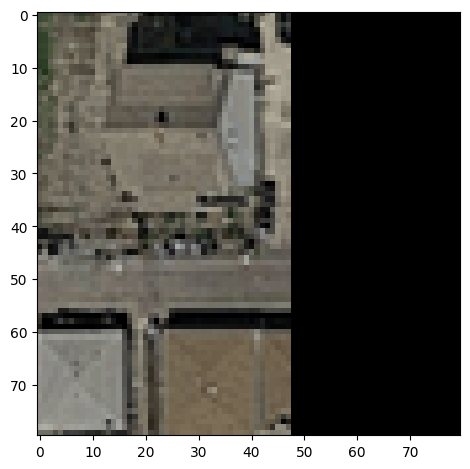

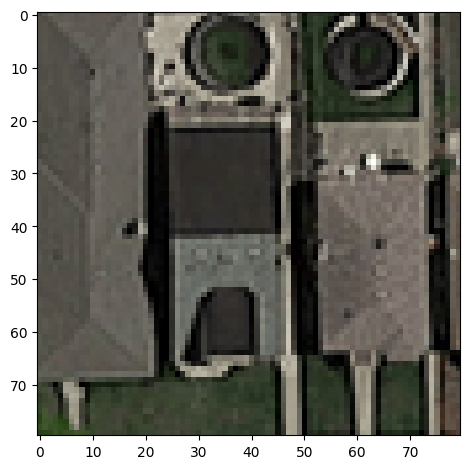

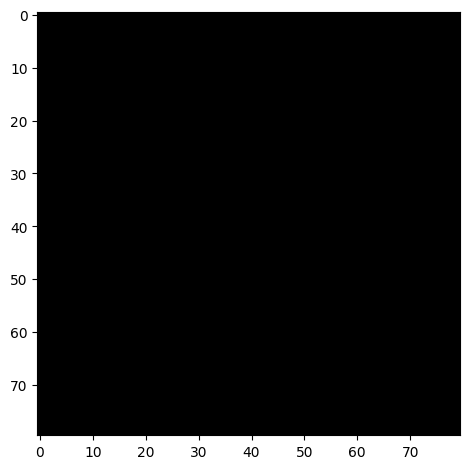

In [88]:
print('We pad the test images to be able to make patches of 80 :')
imshow(imgs[7])
plt.show()

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [89]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 lambda_5 (Lambda)              (None, 80, 80, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 80, 80, 16)   448         ['lambda_5[0][0]']               
                                                                                                  
 dropout_45 (Dropout)           (None, 80, 80, 16)   0           ['conv2d_95[0][0]']              
                                                                                            

 conv2d_110 (Conv2D)            (None, 40, 40, 32)   9248        ['dropout_52[0][0]']             
                                                                                                  
 conv2d_transpose_23 (Conv2DTra  (None, 80, 80, 16)  2064        ['conv2d_110[0][0]']             
 nspose)                                                                                          
                                                                                                  
 concatenate_23 (Concatenate)   (None, 80, 80, 32)   0           ['conv2d_transpose_23[0][0]',    
                                                                  'conv2d_96[0][0]']              
                                                                                                  
 conv2d_111 (Conv2D)            (None, 80, 80, 16)   4624        ['concatenate_23[0][0]']         
                                                                                                  
 dropout_5

In [90]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=25, callbacks=callbacks)

####################################

Epoch 1/25
282/282 [==============================] - 180s 628ms/step - loss: 0.4865 - accuracy: 0.7763 - val_loss: 0.4389 - val_accuracy: 0.7488
Epoch 2/25
282/282 [==============================] - 183s 649ms/step - loss: 0.4129 - accuracy: 0.7920 - val_loss: 0.4189 - val_accuracy: 0.7810
Epoch 3/25
282/282 [==============================] - 183s 649ms/step - loss: 0.3519 - accuracy: 0.8346 - val_loss: 0.3793 - val_accuracy: 0.8037
Epoch 4/25
282/282 [==============================] - 183s 650ms/step - loss: 0.3150 - accuracy: 0.8573 - val_loss: 0.3286 - val_accuracy: 0.8504
Epoch 5/25
282/282 [==============================] - 183s 649ms/step - loss: 0.2819 - accuracy: 0.8759 - val_loss: 0.3354 - val_accuracy: 0.8404
Epoch 6/25
282/282 [==============================] - 183s 649ms/step - loss: 0.2665 - accuracy: 0.8838 - val_loss: 0.3016 - val_accuracy: 0.8589
Epoch 7/25
282/282 [==============================] - 183s 648ms/step - loss: 0.2562 - accuracy: 0.8889 - val_loss: 0.3114 -

In [91]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

100/100 [==============================] - 13s 127ms/step


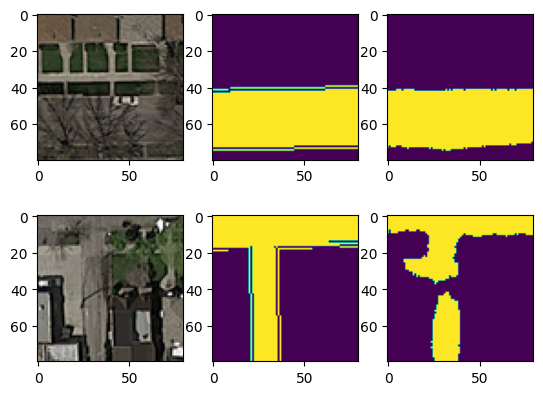

In [92]:
# Perform a sanity check on some random training samples
fig, ax = plt.subplots(2,3)
ix = random.randint(0, len(preds_train_t))
ax[0,0].imshow(X_train[ix])
ax[0,1].imshow(np.squeeze(Y_train[ix]))
ax[0,2].imshow(np.squeeze(preds_train_t[ix]))

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
ax[1,0].imshow(X_train[int(X_train.shape[0]*0.9):][ix])
ax[1,1].imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
ax[1,2].imshow(np.squeeze(preds_val_t[ix]))
plt.show()

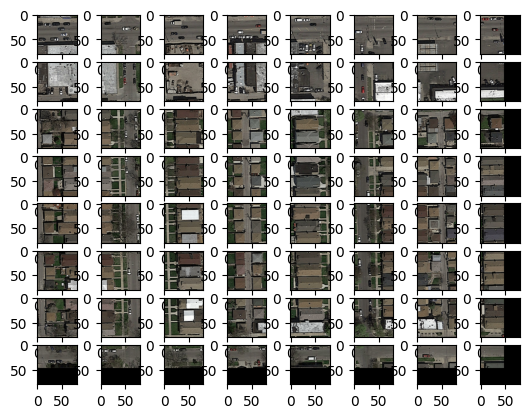

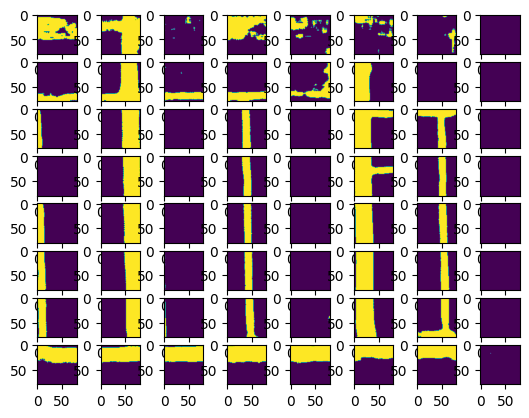

In [93]:
# Look at the prediction for the first image
fig, ax = plt.subplots(8,8) # Works for patchsize = 80
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(X_test[8*i + j])
fig1, ax1 = plt.subplots(8,8) # Works for patchsize = 80
for i in range(8):
    for j in range(8):
        ax1[i,j].imshow(np.squeeze(preds_test_t[8*i + j]))

In [94]:
submission = []
for i, pred in enumerate(preds_test):
    img_id = test_ids[i//64]
    # Format the image id
    id = img_id.split('_')[1].zfill(3)
    preds = helpers.split_into_patches(pred, 16)
    for j, img in enumerate(preds):
        # Calculate the index of each subimage (in terms of pixels)
        x = 16*(5*((i % 64) % 8 ) + j % 5)
        y = 16*(5*((i % 64) // 8) + j // 5)
        # Don't add the padding predictions
        if x < 608 and y < 608:
            # For now we calculate the average over all the pixels and check if it's above 0.5
            submission.append((f"{id}_{x}_{y}", 1 if img.mean() > 0.5 else 0))
np.savetxt("predictions.csv", np.asarray(submission), fmt="%s", delimiter=",", newline="\n", header="id,prediction", comments="")